In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import Input, Dense, Dropout, LeakyReLU, SimpleRNN, GRU, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# ---------- hyperparameters ----------
EPOCHS       = 100
BATCH_SIZE   = 64
ACTION_SPACE = 3
LATENT_SPACE = 64

tf.random.set_seed(10)

Actions: (20002, 3)


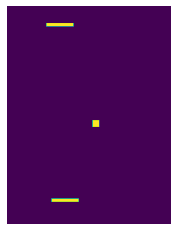

In [3]:
# ---------- training data ----------
actions = np.load('_actions.npy')
one_hots = np.zeros((actions.size, 3))

# [1, 0, 0] -> left
# [0, 1, 0] -> Still
# [0, 0, 1] -> Right
for i in range(actions.size):
    one_hots[i][actions[i]+1] = 1

actions = one_hots
print('Actions: ' + str(actions.shape))

screens = np.load('_screens.npy')
screens = screens.reshape( (-1, 256, 192, 1) )
screens = screens.astype(np.float32)

plt.axis('off')
plt.imshow(screens[0].reshape(256, 192))
plt.show()

## Create the models

In [4]:
# engine
i = Input( shape=(LATENT_SPACE * 2 + ACTION_SPACE) )

x = Dense( 256 )(i)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)

x = Dense( 256 )(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)

x = Dense( 128 )(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)

x = Dense( 128 )(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)

x = Dense( LATENT_SPACE, activation='sigmoid' )(x)

engine = Model(i, x, name='model_3')
engine.compile( loss='mse', optimizer=RMSprop(lr=0.0001) )
print(engine.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 131)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               33792     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

In [5]:
# encoder
encoder = tf.keras.models.load_model('models/encoder.h5')
encoder.trainable = False
print(encoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 192, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 96, 8)        136       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 96, 8)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 48, 16)        2064      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 16)        4112      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 24, 16)        0     

In [6]:
# renderer
renderer = tf.keras.models.load_model('models/decoder.h5')
renderer.trainable = False
print(renderer.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6144)              399360    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6144)              0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 12, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 24, 32)        16416     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 48, 16)        3278

In [7]:
# model
i = Input( shape=(LATENT_SPACE * 2 + ACTION_SPACE) )
x = engine(i)
x = renderer(x)

model = Model(i, x)
model.compile( loss='binary_crossentropy', optimizer='rmsprop' )

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 131)]             0         
_________________________________________________________________
model_3 (Model)              (None, 64)                157248    
_________________________________________________________________
model_1 (Model)              (None, 256, 192, 1)       464953    
Total params: 622,201
Trainable params: 157,248
Non-trainable params: 464,953
_________________________________________________________________
None


## Format Training Data

In [8]:
# encoded the screens
encoded_frames = encoder.predict(screens)

Xs = []
Ys = []
for i in range(1, encoded_frames.shape[0] - 1):
    Xs.append(encoded_frames[i - 1].tolist() + encoded_frames[i].tolist() + actions[i].tolist())
    Ys.append(screens[i + 1])
    
Xs = np.asarray(Xs)
Xs = np.reshape(Xs, (Xs.shape[0], -1))

Ys = np.asarray(Ys)

print(Xs.shape)
print(Ys.shape)

(20000, 131)
(20000, 256, 192, 1)


## Training

In [ ]:
# ---------- training loop ----------
history = model.fit( x=Xs, y=Ys, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.02)
history = history.history

Train on 19600 samples, validate on 400 samples
Epoch 1/100
19600/19600 [==============================] - 33s 2ms/sample - loss: 0.0425 - val_loss: 0.0160
Epoch 2/100
19600/19600 [==============================] - 18s 934us/sample - loss: 0.0144 - val_loss: 0.0111
Epoch 3/100
19600/19600 [==============================] - 18s 943us/sample - loss: 0.0109 - val_loss: 0.0082
Epoch 4/100
19600/19600 [==============================] - 18s 941us/sample - loss: 0.0091 - val_loss: 0.0077
Epoch 5/100
19600/19600 [==============================] - 18s 943us/sample - loss: 0.0082 - val_loss: 0.0066
Epoch 6/100
19600/19600 [==============================] - 18s 943us/sample - loss: 0.0075 - val_loss: 0.0064
Epoch 7/100
19600/19600 [==============================] - 19s 945us/sample - loss: 0.0070 - val_loss: 0.0058
Epoch 8/100
19600/19600 [==============================] - 19s 947us/sample - loss: 0.0067 - val_loss: 0.0060
Epoch 9/100
19600/19600 [==============================] - 19s 950us/sampl

19600/19600 [==============================] - 19s 958us/sample - loss: 0.0037 - val_loss: 0.0035
Epoch 75/100
19600/19600 [==============================] - 19s 957us/sample - loss: 0.0037 - val_loss: 0.0033
Epoch 76/100
19600/19600 [==============================] - 19s 959us/sample - loss: 0.0037 - val_loss: 0.0032
Epoch 77/100
19600/19600 [==============================] - 19s 957us/sample - loss: 0.0037 - val_loss: 0.0031
Epoch 78/100
19600/19600 [==============================] - 19s 957us/sample - loss: 0.0037 - val_loss: 0.0031
Epoch 79/100
19600/19600 [==============================] - 19s 957us/sample - loss: 0.0037 - val_loss: 0.0032
Epoch 80/100
19600/19600 [==============================] - 19s 958us/sample - loss: 0.0037 - val_loss: 0.0028
Epoch 81/100
12864/19600 [==================>...........] - ETA: 6s - loss: 0.0037

## Error visualization

In [ ]:
# plot model loss over time
plt.plot(history['loss']        , label='loss')
plt.plot(history['val_loss']    , label='val_loss')

plt.legend(loc=1)
plt.show()

In [ ]:
# see how quickly the model diverges
samples = Xs[:160]

predicted_screens = model.predict(samples)
true_screens = screens[2:162]

# render the predicted & actual screens
images = np.concatenate((true_screens[::4], predicted_screens[::4]))

# Create a figure from the predicted and real images
cols, rows = 40, 2
fig=plt.figure(figsize=(40, 2))

for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(images[i-1])

# Save the figure to the images dir
plt.show()

In [ ]:
predictions = encoded_frames[:2]

for i in range(1, 199):
    
    inputs = encoded_frames[i - 1].tolist() + encoded_frames[i].tolist() + [0, 1, 0]
    inputs = np.asarray(inputs)
    
    prediction = engine.predict(np.reshape(inputs, (-1, 131 )))
    predictions = np.concatenate((predictions, prediction))

predictions = renderer.predict(predictions)
print(predictions.shape)

In [ ]:
cols, rows = 100, 1
fig=plt.figure(figsize=(100, 1))

for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(predictions[i-1])

plt.show()

In [14]:
engine.save('models\engine.h5')